# Fraud Detection from Credit Card History, Machine learning algorithms
The following jupyter notebook contains a binary classification for fraud detection, from a credit card history. For this; we will explore the following three machine learning algorithms:
* Logistic Regression
* Decision Tree
* Linear Support Vector Machine

This jupyter notebook would showcase the following:
1. Confusion matrix for each of the models
2. Cross validation metrics (precision, recall, f1_score, accuracy_score).
3. Plot of probability distributions between real test data vs each models predictions.

In [ ]:
import sys
import os
import pandas as pd
import copy
import matplotlib.pyplot as plt

# Get the root project path
root_project_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

#Append it to sys
sys.path.append(root_project_path)

#Import the necessary modules
from utils import DataLoader, CreditCardPreprocesser

### Load the data

In [ ]:
#Set the folder name and data folder
folder_name = "data"
data_holder_path = os.path.join(os.getcwd(), os.pardir)

#Set the folder name
data_loader = DataLoader(data_folder_name=folder_name,
    data_folder_path=data_holder_path)

#Get the data
df_data = data_loader.get_dataset()

### Get the preprocessed dataframe

In [3]:
#Create an instance of the Credit card processer
credit_card_processer = CreditCardPreprocesser(df_data=df_data)

#Obtain the df_preprocessed
df_preprocessed = credit_card_processer.fetch_preprocessed_dataframe()

In [ ]:
df_preprocessed.shape

In [ ]:
df_preprocessed.info()

### Select the X and Y target

In [ ]:
X: pd.DataFrame = df_preprocessed[[col for col in df_preprocessed.columns if col != "is_fraud"]]
y: pd.DataFrame = df_preprocessed["is_fraud"]

In [7]:
y.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

### Lets now oversample it using SMOTE

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

#Obtain the over sampled new values
X_smote, y_smote = smote.fit_resample(X.astype("float"), y)

In [9]:
y_smote.value_counts()

is_fraud
0    1289169
1    1289169
Name: count, dtype: int64

### Select the continous columns:

We will select the continous columns; where we are going to apply our `Standardscaler()` instance from scikit-learn to perform standardscaling on ONLY the continous features.

In [ ]:
#List all the continous features
continous_features = ["cc_num", "amt", "zip", "lat", "long", "city_pop", "unix_time",
    "merch_lat", "merch_long", "merch_zipcode", "transaction_year", "transaction_month",
    "transaction_day", "transaction_hour", "transaction_minute", "transaction_second",
    "birth_year", "birth_month", "birth_day", "merchant_encoded", "merchant_freq",
    "first_encoded", "first_freq", "last_encoded", "last_freq", "street_encoded",
    "street_freq", "city_encoded", "city_freq", "job_encoded", "job_freq"]

#Select the continous and not continous 
X_smote_continous = X_smote[continous_features]
X_smote_discontinous = X_smote[[c for c in X_smote.columns if c not in continous_features]]

In [ ]:
X_smote_discontinous.head(3)

### Implement the standardscaler to continous features

In [ ]:
# Importing standard scaler
from sklearn.preprocessing import StandardScaler

#Create a standard scaler object and fit x_train
standard_scaler = StandardScaler()
standard_scaler.fit(X_smote_continous)

#Transform x_train and x_test
X_continous_scaled = standard_scaler.transform(X_smote_continous)

In [ ]:
# Now lets make a pandas dataframe
X_continous_scaled = pd.DataFrame(X_continous_scaled,
    columns=X_smote_continous.columns)

In [ ]:
X_continous_scaled.shape

In [15]:
X_continous_scaled.head(3)

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,merch_zipcode,...,first_encoded,first_freq,last_encoded,last_freq,street_encoded,street_freq,city_encoded,city_freq,job_encoded,job_freq
0,-0.314271,-0.849194,-0.730280,-0.492459,0.634399,-0.285407,-1.757957,-0.501585,0.571740,-0.748664,...,-0.082518,1.395777,-0.301838,-0.634478,-0.348532,0.578649,-0.335681,0.202575,-0.255668,-0.059291
1,-0.316360,-0.552679,1.876215,2.010268,-2.009971,-0.296102,-1.757955,2.050549,-2.006061,-0.014423,...,-0.201182,0.425417,-0.227438,-0.472078,-0.348532,1.795431,-0.335681,1.621002,-0.243346,0.686414
2,-0.316331,-0.225370,1.288122,0.699800,-1.585207,-0.283301,-1.757955,0.884259,-1.575789,1.585286,...,-0.273969,-0.747942,-0.054244,0.177040,-0.348532,-1.273240,-0.335681,-1.223333,0.114519,-1.515191


### Create the actual datasets.

In [ ]:
# These are the new datasets
X_data = pd.concat([X_continous_scaled, X_smote_discontinous], axis=1)
y_data = copy.copy(y_smote)

In [ ]:
# Print the shapes
print(X_data.shape)
print(y_data.shape)

### Initialize the following classifiers
Now we will initialize each of the classifiers, and perform cross validation to obtain all the different metrics.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

In [37]:
class LSTMModel:
    def __init__(self, input_shape, epochs=5, batch_size=32, learning_rate=0.001):
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def fit(self, X, y):
        # Reshape input for LSTM
        X_lstm = np.expand_dims(X, axis=2)

        # Define LSTM architecture
        self.model = Sequential([
            Input(shape=(X_lstm.shape[1], X_lstm.shape[2])),
            LSTM(64, return_sequences=True),
            LSTM(32),
            Dense(1, activation="sigmoid")
        ])

        # Compile the model
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

        # Train the model
        self.model.fit(X_lstm, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        return self

    def predict(self, X):
        # Reshape input for prediction
        X_lstm = np.expand_dims(X, axis=2)
        predictions = self.model.predict(X_lstm).flatten()
        return (predictions > 0.5).astype(int)

In [38]:
ml_classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Linear Support Vector Machine": LinearSVC(C=1.0, max_iter=1000),
    "LSTM Classifier": LSTMModel(input_shape=(X_data.shape[1], 1), epochs=5, batch_size=32, learning_rate=0.001)
}

### Split the data
We would like to perform the following:
1. Split our data into train_validation and test; we would hold the test dataset for a final analysis.
2. Perform cross validation using train_validation; and perform shuffled folds to see its accuracies.
3. Keep the saved cross val scores; for later analysis.

In [39]:
# Obtain the data into train_val and test
x_train_val, x_test, y_train_val, y_test = train_test_split(X_data, y_data,
    test_size=0.2, shuffle=True, random_state=42)
print(x_train_val.shape)
print(x_test.shape)
print(y_train_val.shape)
print(y_test.shape)

(2062670, 95)
(515668, 95)
(2062670,)
(515668,)


### Perform Cross validation for all ML algorithms
Perform cross validation for each of the ML algorithms, to obtain its results.

In [ ]:
# Create the holders for each metrics
ml_metrics = {}

for name, clf in ml_classifiers.items():
    print(f"\n==========={name}============ Starting")
    # Initialize variables for each
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Set loop count
    loop_count = 1 if name == "LSTM Classifier" else 20

    for i in range(loop_count):
        print(f"Iteration: {i} - {name}")
        # Call the train test split
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, shuffle=True)

        # Fit each of the classifiers
        clf.fit(X=x_train, y=y_train)

        # Obtain the predictions for both
        y_pred = clf.predict(x_val)

        # Append metrics
        accuracies.append(accuracy_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))

    # Add the metrics
    ml_metrics[name + "_accuracies"] = accuracies
    ml_metrics[name + "_precisions"] = precisions
    ml_metrics[name + "_recalls"] = recalls
    ml_metrics[name + "_f1_scores"] = f1_scores

    # Create a dataframe and save it into a dataframe
    df_results = pd.DataFrame(ml_metrics)
    df_results.to_csv('my_data_' + name.replace(" ", "_") + '.csv', index=False)
    print(f"\n==========={name}============ Ending")


===========Logistic Regression============ Starting
Iteration: 0 - Logistic Regression


# Data Visualization

Now that we have finally got the cross validation metrics, we will perform the last steps in order to see the different results of each of the ML models. This would be illustrated as:

1. Plot bar plot of accuracies, precision, recall, and f1 score for cross validation metrics of each of the models.

2. Next; after having the cross validation metrics; we previously have isolated a part of the data as test set. We are going to train a final model for each ML classifier, and obtain the test metrics as well. With these test and cross validation metrics; we are going to perform the following:
3. Plot bar plot of accuracies, precision, recall, and f1 score for test metrics of each of the models.
4. Generate confusion matrices for each of the test final models.
5. Create ROC curves for all models and overlay for comparison

In [ ]:
from typing import List
def read_df_data(clfs_names:List[str]) -> pd.DataFrame:
    """
    Function that would retrieve the checkpoints cross validation
    values for accuracy, precision, recall, and f1 score.
    """
    #Create a holder to store the data
    actual_data = {}

    for name in clfs_names:
        #Read the dataframe
        df_data = pd.read_csv("my_data_" + name + ".csv")

        #Assign it to the actual data properly
        actual_data[name + "_accuracies"] = df_data[name + "_accuracies"].to_numpy()
        actual_data[name + "_precisions"] = df_data[name + "_precisions"].to_numpy()
        actual_data[name + "_recalls"] = df_data[name + "_recalls"].to_numpy()
        actual_data[name + "_f1_scores"] = df_data[name + "_f1_scores"].to_numpy()
    
    #Return the total dataframe.
    return pd.DataFrame(actual_data)

In [ ]:
#Get the cross validation metrics
df_cross_val_metrics = read_df_data(clfs_names=ml_classifiers.keys())

print(ml_classifiers.keys())


In [ ]:
df_cross_val_metrics.columns

In [56]:
df_cross_val_metrics.head(2)

,Logistic Regression_accuracies,Logistic Regression_precisions,Logistic Regression_recalls,Logistic Regression_f1_scores,Decition Tree Classifier_accuracies,Decition Tree Classifier_precisions,Decition Tree Classifier_recalls,Decition Tree Classifier_f1_scores,Linear Support Vector Machine_accuracies,Linear Support Vector Machine_precisions,Linear Support Vector Machine_recalls,Linear Support Vector Machine_f1_scores
0,0.899715,0.928023,0.866518,0.896217,0.998449,0.997649,0.999251,0.998449,0.885267,0.921700,0.842319,0.880223
1,0.899538,0.927577,0.866385,0.895937,0.998449,0.997624,0.999284,0.998453,0.884928,0.919574,0.843096,0.879676


### Plot the cross validation bar plots

In [ ]:
# Create two lists for a new dataframe, models and metrics
models = ml_classifiers.keys()
metrics = ["accuracies", "precisions", "recalls", "f1_scores"]

#Lets do a df plot cross val
plot_cross_val = []
for model in models:
    model_data = [df_cross_val_metrics[f"{model}_{metric}"].mean() for metric in metrics]
    plot_cross_val.append(model_data)

# Convert to a Pandas DataFrame for plotting
df_plot_cross_val = pd.DataFrame(plot_cross_val, columns=metrics, index=models)

In [ ]:
df_plot_cross_val.head(3)

### Plot the bar graph of cross val metrics

In [ ]:
fig, axs = plt.subplots(1, figsize = (12, 6))
df_plot_cross_val.T.plot(ax=axs, kind="bar", legend=True, width = 0.8)

# Rotate x-axis ticks
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, fontsize=10)

# Annotate bar values
for container in axs.containers:
    axs.bar_label(container, fmt='%.4f', fontsize=10, padding=3)

axs.set_ylim(0.83, 1.01)

### Train the final test models!
Even thought its obvious the decision tree classifier is the best model between all the ML models; now we will perform the final test models and retrieve the metrics for each of them.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Create the holders for each metrics
test_metrics = []
conf_matrices = []
class_reports = []
roc_auc_scores = []

for name, clf in ml_classifiers.items():
    print(f"\n==========={name}============ Starting")

    # Fit the model with x_train_val and the y_train_val dataset now!
    clf.fit(X=x_train_val, y=y_train_val)

    #Obtain the predictions for both
    y_pred = clf.predict(x_test)

    # Append them in order per row (accuracy, precision, recall, f1_score)
    test_metrics.append(accuracy_score(y_test, y_pred))
    test_metrics.append(precision_score(y_test, y_pred))
    test_metrics.append(recall_score(y_test, y_pred))
    test_metrics.append(f1_score(y_test, y_pred))

    # Append the confusion matrix
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    class_reports.append(classification_report(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred))

    print(f"\n==========={name}============ Ending")

In [ ]:
print(test_metrics)

In [ ]:
# Convert this to a numpy array
import numpy as np
np_test_metrics = np.array(test_metrics)
np_test_metrics = np_test_metrics.reshape(3,4)

In [ ]:
print(np_test_metrics)

In [71]:
#Create a dataframe of the model the test metrics
df_test_results = pd.DataFrame(np_test_metrics, columns=metrics, index=models)
print(df_test_results.head(4))

                               accuracies  precisions   recalls  f1_scores
Logistic Regression              0.900360    0.929433  0.867051   0.897159
Decition Tree Classifier         0.998751    0.998118  0.999393   0.998755
Linear Support Vector Machine    0.886353    0.922740  0.843939   0.881582


(0.83, 1.01)

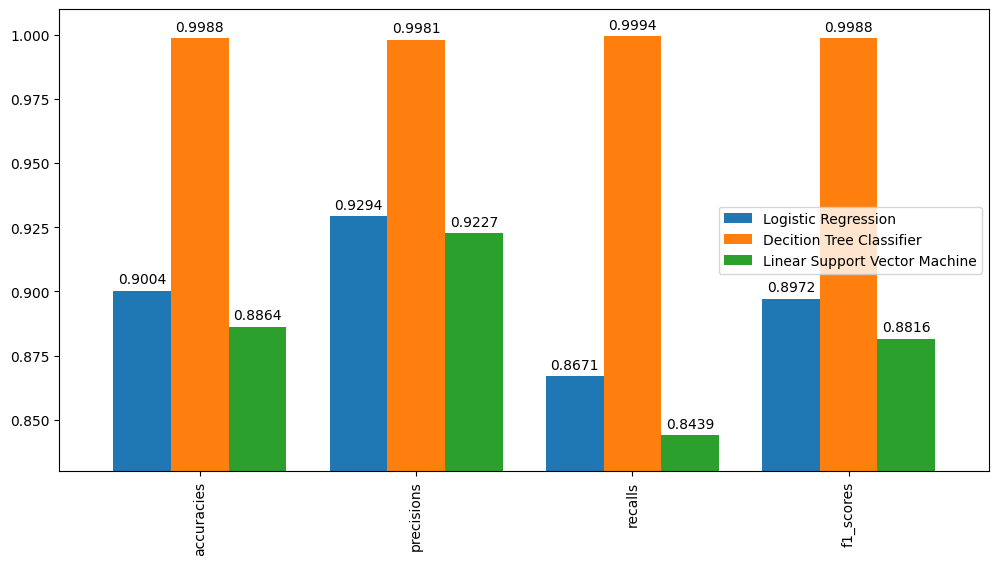

In [72]:
fig, axs = plt.subplots(1, figsize = (12, 6))
df_test_results.T.plot(ax=axs, kind="bar", legend=True, width = 0.8)

# Rotate x-axis ticks
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, fontsize=10)

# Annotate bar values
for container in axs.containers:
    axs.bar_label(container, fmt='%.4f', fontsize=10, padding=3)  # Adjust padding for better visibility

axs.set_ylim(0.83, 1.01)

### Print each of the classification reports

In [ ]:
for i, name in enumerate(ml_classifiers):
    print(f"\n==========={name}============ class report")
    print(class_reports[i])

### Lets lot the confusion matrices now

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

for i, name in enumerate(ml_classifiers):
    cm = conf_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
    disp.plot()
    plt.suptitle(name)

### Finally, lets plot the ROC auc scores

In [78]:
for i, name in enumerate(ml_classifiers):
    print(f"{name} ROC_AUC_Scores: {roc_auc_scores[i]}")

Logistic Regression ROC_AUC_Scores: 0.9004442354715528
Decition Tree Classifier ROC_AUC_Scores: 0.998749518209659
Linear Support Vector Machine ROC_AUC_Scores: 0.886460101365459
